In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy.stats
%matplotlib inline



In [6]:
data = pd.read_csv('AirPassengers.csv', header = 0, parse_dates = ['Month'], index_col = 'Month')

In [7]:
data[['Passengers']] = data[['#Passengers']] ; data.drop('#Passengers', axis = 1, inplace = True)
#data.colnames = 'Passengers'

In [23]:
data.head(5)

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [36]:
data.Passengers.head(4)

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
Name: Passengers, dtype: int64

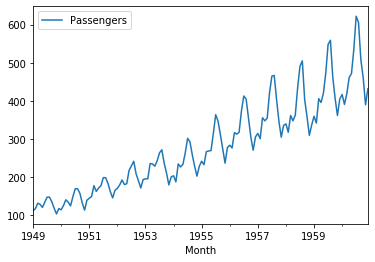

In [25]:
data.plot()

In [32]:
data.size

144

In [38]:
TRAIN_SIZE = 120

In [184]:
data_train = data.iloc[range(TRAIN_SIZE)]
data_test = data.iloc[range(TRAIN_SIZE, data.size)]
x_train = np.array(range(0, data_train.size))
x_test = np.array(range(data_train.size, data.size))

In [41]:
data_test.size

24

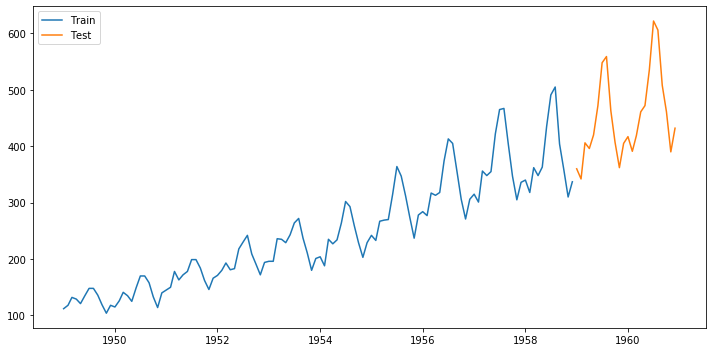

In [44]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(data_train, label = 'Train')
ax.plot(data_test, label = 'Test')
ax.legend()
plt.tight_layout()

In [142]:
# Voy a predecir con el seasonal_decompose modelo y voy a hacer una predicción
from statsmodels.tsa.seasonal import seasonal_decompose

In [53]:
model1 = seasonal_decompose(np.log(data_train), model = 'additive') #Hacer esto es equivalente a poner multiplicativo, 
                                                                    #y entrandole heterocedasticidad (sin el log),
                                                                    #Pero ojo las unidades son diferentes

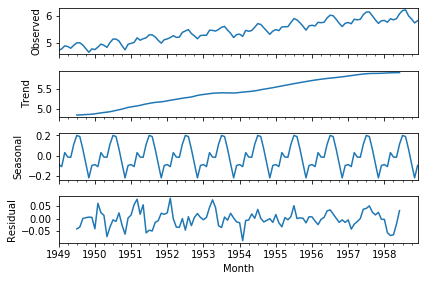

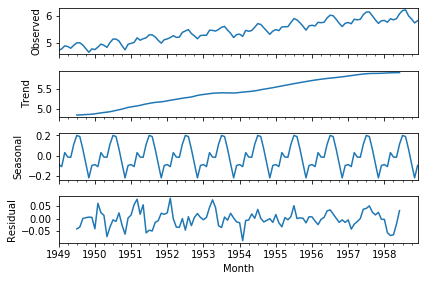

In [54]:
model1.plot()

In [51]:
model2 = seasonal_decompose(data_train, model = 'multiplicative')

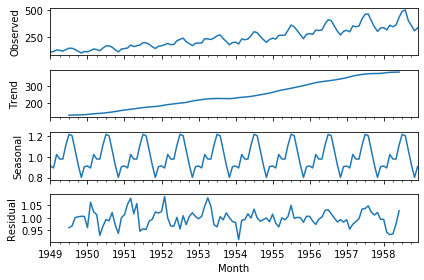

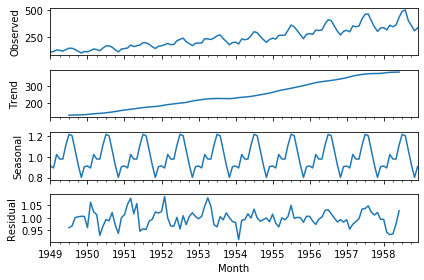

In [52]:
model2.plot()

In [68]:
model2.resid.dropna(inplace = True)

In [71]:
# Compruebo que los residuos son una distribucion normal (Shapiro test):

results = scipy.stats.shapiro(model2.resid.values)
results  # P-values es 0.222 por lo tanto se cumple la hipotesis nula, es normal

(0.983996570110321, 0.22238335013389587)

In [73]:
mu, sigma = scipy.stats.norm.fit(model2.resid)
print(mu, sigma)

0.997894280816399 0.031168626299925457


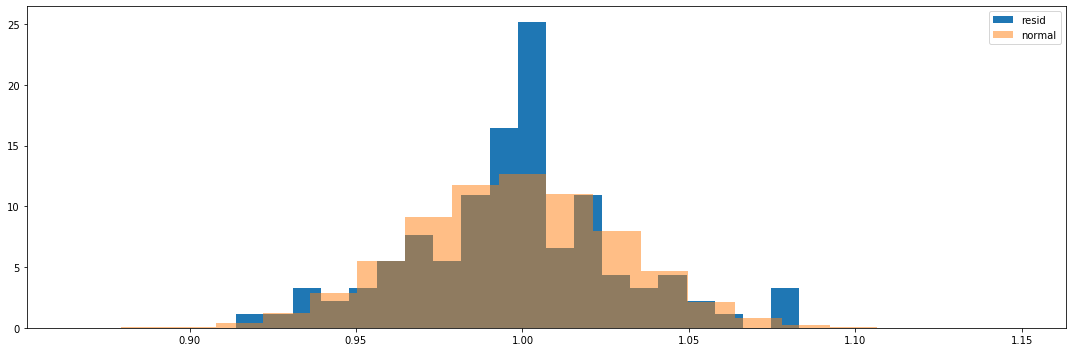

In [88]:
fig, ax = plt.subplots(1, 1, figsize = (15, 5))
ax.hist(model2.resid.values.squeeze(), bins = 20,  label = "resid", density = True)
ax.hist(np.random.normal(mu, sigma, size = 100000), bins = 20, label = "normal", alpha = 0.5, density = True)
plt.legend()
plt.tight_layout()

In [90]:
N_SAMPLES = 1000
err_test = np.random.normal(mu, sigma, size = (N_SAMPLES, data_test.size))

In [129]:
prediction = err_test * model2.seasonal.values.squeeze()[0:data_test.size] * trend_test.squeeze()

In [92]:
from sklearn.linear_model import LinearRegression

In [475]:
df = pd.DataFrame({'a' : model2.trend.values.squeeze(), 'b' : x_train} )
df.dropna(inplace = True)

In [476]:
modelreg = LinearRegression()
modelreg.fit(df[['b']], df[['a']])
trend_test = modelreg.predict(x_test.reshape(-1, 1))

In [135]:
prediction_mean_mult = pd.DataFrame(prediction).apply(np.mean, axis = 0)

In [136]:
prediction_median_mult = pd.DataFrame(prediction).apply(np.median, axis = 0)

In [128]:
trend_test.squeeze()

array([400.02432305, 402.59044542, 405.15656779, 407.72269016,
       410.28881253, 412.8549349 , 415.42105727, 417.98717963,
       420.553302  , 423.11942437, 425.68554674, 428.25166911,
       430.81779148, 433.38391385, 435.95003622, 438.51615858,
       441.08228095, 443.64840332, 446.21452569, 448.78064806,
       451.34677043, 453.9128928 , 456.47901516, 459.04513753])

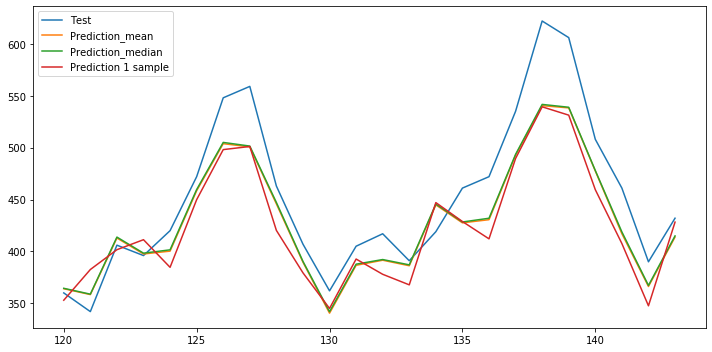

In [536]:
fig, ax = plt.subplots(figsize=(10,5))
#ax.plot(x_train, data_train, label = 'Train')
ax.plot(x_test, data_test, label = 'Test')
ax.plot(x_test, prediction_mean_mult, label = 'Prediction_mean')
ax.plot(x_test, prediction_median_mult + 1, label = 'Prediction_median')
ax.plot(x_test, prediction[10,:], label="Prediction 1 sample")
ax.legend()
plt.tight_layout()

In [159]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

In [163]:
print('median_mae_error = ', mae(data_test.values.squeeze(), prediction_median_mult.squeeze()))
print('median_rmse_error = ', np.sqrt(mse(data_test.values.squeeze(), prediction_median_mult.squeeze())), '\n')

print('mean_mae_error = ', mae(data_test.values.squeeze(), prediction_mean_mult.squeeze()))
print('mean_rmse_error = ', np.sqrt(mse(data_test.values.squeeze(), prediction_mean_mult.squeeze())))

median_mae_error =  28.154030619368623
median_rmse_error =  34.48946839462469 

mean_mae_error =  28.256353523240424
mean_rmse_error =  34.5331777251477


In [164]:
# Ahora vamos con ARIMA MODELO, ya tenemos una baseline

In [167]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

In [172]:
data_train.head(5)

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [ ]:
# Data es una serie estacionaria? No porque vemos una tendencia y una seasonality

In [526]:
data_train = np.log(data_train) # Quitamos heterocedasticidad

In [ ]:
# Haremos plot de los data_train.diff() para diferentes ordenes

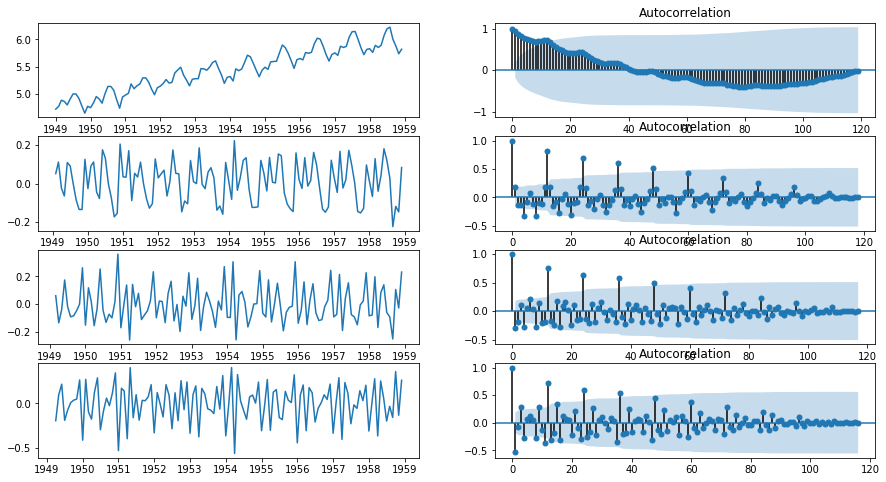

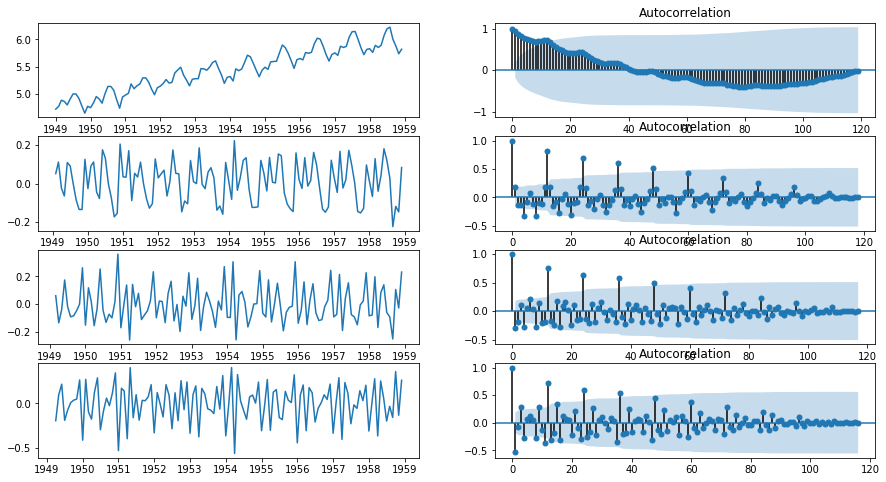

In [527]:
fig, ax = plt.subplots(4, 2, figsize=(15,8))
ax[0][0].plot(data_train)
plot_acf(data_train.values, ax = ax[0][1])
ax[1][0].plot(data_train.diff().dropna())
plot_acf(data_train.diff().dropna(), ax = ax[1][1])
ax[2][0].plot(data_train.diff().diff().dropna())
plot_acf((data_train.diff()).diff().dropna(), ax = ax[2][1])
ax[3][0].plot(data_train.diff().diff().diff().dropna())
plot_acf(((data_train.diff()).diff()).diff().dropna(), ax = ax[3][1])

#Como aprecio en los plots, no nos estamos quitando la componente estacional al diferenciar, solo nos quita la tendencia
# y eso nos impide ver bien el grado d

In [201]:
# Que hago? 2 opciones, o trato directamente con los residuos obtenidos por el seasonal_decompose o trabajo con SARIMA.


## OPCION 1

In [482]:
data_train = data.iloc[range(TRAIN_SIZE)]
data_test = data.iloc[range(TRAIN_SIZE, data.size)]
x_train = np.array(range(0, data_train.size))
x_test = np.array(range(data_train.size, data.size))

In [403]:
#model1 = seasonal_decompose(np.log(data_train), model = 'additive')
#data_train_res = model1.resid  # Tanto en el residuo, como la trend como seasonality se me cuelan 6 valores de NAN pero ojo
                                #en seasonal no se cuela ninguno

In [483]:
model1 = seasonal_decompose(data_train, model = 'multiplicative')
data_train_res = model1.resid  # Tanto en el residuo, como la trend como seasonality se me cuelan 6 valores de NAN pero ojo
                                #en seasonal no se cuela ninguno

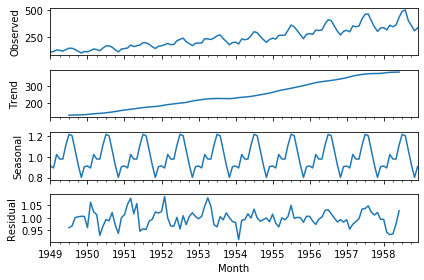

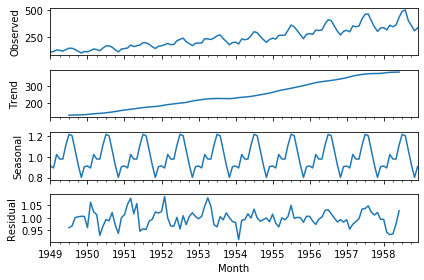

In [484]:
model1.resid.head(10)   # Tengo 6 de inicio que son de infinito y seis de cola que tambien
model1.resid.tail(10)
model1.resid.head(10)
model1.seasonal.head(4)
model1.plot()

In [485]:
model1.seasonal.size

120

In [486]:
df = pd.DataFrame({'a' : model1.trend.values.squeeze(), 'b' : x_train} )
df.dropna(inplace = True)
modelreg = LinearRegression()
modelreg.fit(df[['b']], df[['a']])
trend_test = modelreg.predict(x_test.reshape(-1, 1))

In [487]:
data_train_res = data_train_res.dropna()

(-0.5, 0.8)

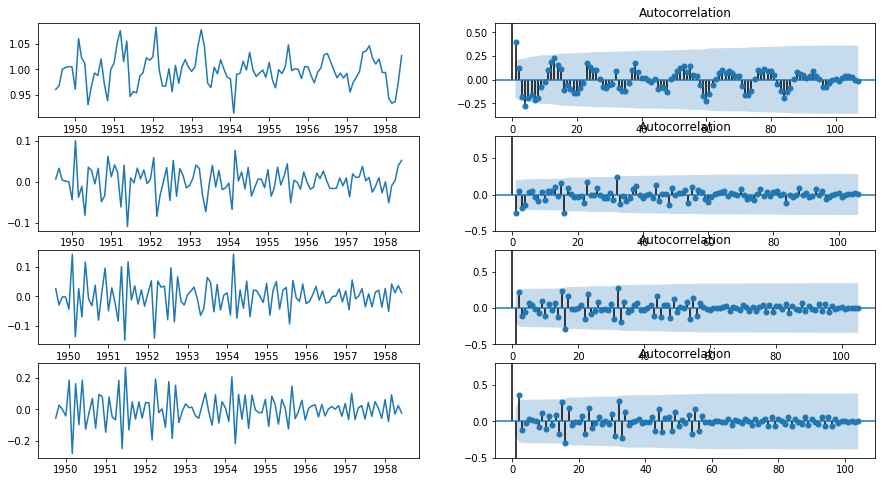

In [488]:
fig, ax = plt.subplots(4, 2, figsize=(15,8))
ax[0][0].plot(data_train_res)
plot_acf(data_train_res.values, ax = ax[0][1])
ax[1][0].plot(data_train_res.diff().dropna())
plot_acf(data_train_res.diff().dropna(), ax = ax[1][1])
ax[2][0].plot(data_train_res.diff().diff().dropna())
plot_acf((data_train_res.diff()).diff().dropna(), ax = ax[2][1])
ax[3][0].plot(data_train_res.diff().diff().diff().dropna())
plot_acf(((data_train_res.diff()).diff()).diff().dropna(), ax = ax[3][1])
ax[0][1].set_ylim((-0.4, 0.6))
ax[1][1].set_ylim((-0.5, 0.8))
ax[2][1].set_ylim((-0.5, 0.8))
ax[3][1].set_ylim((-0.5, 0.8))

#Viendo el acf.plot ya me hace pensar que el nuevo data.train es estacionaria y no hace falta 
#diferenciar. También podemos sacar el orden # de q en la primera grafica en la derecha: q = 1

In [489]:
# lo compruebo con el test de adfuller
from statsmodels.tsa.stattools import adfuller
results = adfuller(data_train_res.values.squeeze())

In [490]:
results  #Como la hipotesis nula asume que no es estacionaria y tenemos un p-value muy cerca de 0, entonces la rechazamos
#Es estacionaria

(-6.050760448719036,
 1.2792818690155298e-07,
 7,
 100,
 {'1%': -3.497501033, '5%': -2.89090644, '10%': -2.5824349},
 -413.522385690032)

/home/om/anaconda3/envs/masters/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


(-0.6, 0.6)

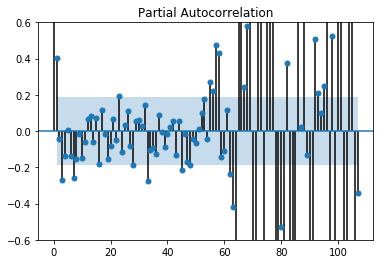

In [491]:
# Y el orden p?  # p = 1
fig, ax = plt.subplots()
plot_pacf(data_train_res, ax = ax)
ax.set_ylim((-0.6,0.6))   

In [244]:
# Tenemos un ARIMA(1, 0, 1) con data_train_res estacionario y no tiene componente estacional

In [492]:
model3 = ARIMA(data_train_res.values.reshape(-1,1), order = (1, 0, 1))
model_fit = model3.fit(disp=0)

In [493]:
data_train_res.size

108

In [494]:
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  108
Model:                     ARMA(1, 1)   Log Likelihood                 230.928
Method:                       css-mle   S.D. of innovations              0.028
Date:                Thu, 16 Apr 2020   AIC                           -453.856
Time:                        17:15:51   BIC                           -443.128
Sample:                             0   HQIC                          -449.506
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9979      0.004    221.940      0.000       0.989       1.007
ar.L1.y        0.3624      0.162      2.232      0.028       0.044       0.681
ma.L1.y        0.0513      0.158      0.324      0.7

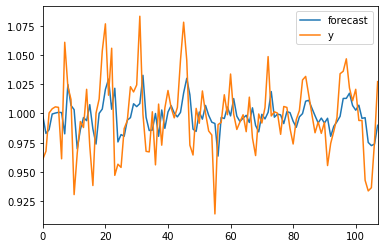

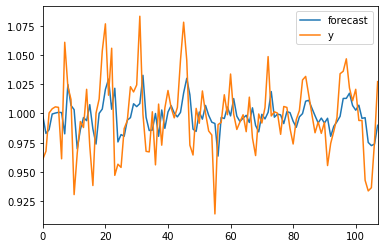

In [495]:
fig, ax = plt.subplots()
model_fit.plot_predict(ax = ax)

In [496]:
forecast11 = model_fit.predict(start=120, end=144) #Me funciona mal

In [497]:
forecast11

array([1.01041799, 1.00241374, 0.99951278, 0.99846139, 0.99808033,
       0.99794223, 0.99789218, 0.99787404, 0.99786746, 0.99786508,
       0.99786422, 0.9978639 , 0.99786379, 0.99786375, 0.99786373,
       0.99786373, 0.99786373, 0.99786372, 0.99786372, 0.99786372,
       0.99786372, 0.99786372, 0.99786372, 0.99786372, 0.99786372,
       0.99786372, 0.99786372, 0.99786372, 0.99786372, 0.99786372,
       0.99786372, 0.99786372, 0.99786372, 0.99786372, 0.99786372,
       0.99786372, 0.99786372])

In [498]:
forecast1 = model_fit.forecast(steps = 24)[0]

In [447]:
forecast1

array([1.0012707 , 1.00018034, 0.99991038, 0.99984354, 0.999827  ,
       0.9998229 , 0.99982189, 0.99982163, 0.99982157, 0.99982156,
       0.99982155, 0.99982155, 0.99982155, 0.99982155, 0.99982155,
       0.99982155, 0.99982155, 0.99982155, 0.99982155, 0.99982155,
       0.99982155, 0.99982155, 0.99982155, 0.99982155])

In [499]:
data_train_res.tail(10)

,Passengers
Month,
1957-09-01,1.021744
1957-10-01,1.010797
1957-11-01,1.020642
1957-12-01,0.993990
1958-01-01,0.993972
1958-02-01,0.942839
1958-03-01,0.933715
1958-04-01,0.936480
1958-05-01,0.975443


In [500]:
pd.DataFrame(forecast1).head(5)

,0
0,1.010418
1,1.002414
2,0.999513
3,0.998461
4,0.998080


In [312]:
forecast1.size

24

In [271]:
# Me doy cuenta que el Pvalue para el coefieciente MA(1) no es significante, lo quito

In [501]:
model4 = ARIMA(data_train_res.dropna().values.reshape(-1,1), order = (1, 0, 0))
model_fit2 = model4.fit(disp=0)
print(model_fit2.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  108
Model:                     ARMA(1, 0)   Log Likelihood                 230.875
Method:                       css-mle   S.D. of innovations              0.029
Date:                Thu, 16 Apr 2020   AIC                           -455.750
Time:                        17:16:28   BIC                           -447.704
Sample:                             0   HQIC                          -452.488
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9978      0.005    217.892      0.000       0.989       1.007
ar.L1.y        0.4047      0.088      4.578      0.000       0.231       0.578
                                    Roots           

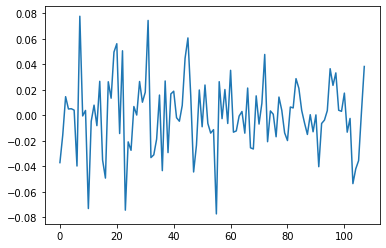

In [502]:
# Compruebo que los residuos sean normales al hacer 
plt.plot(model_fit2.resid)
results = scipy.stats.shapiro(model_fit2.resid)


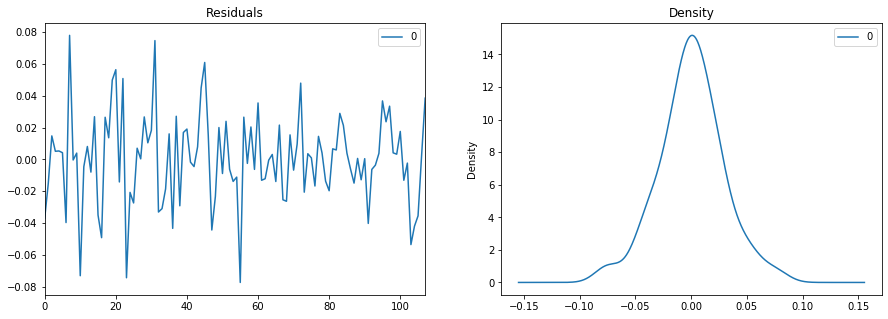

In [504]:
residuals = pd.DataFrame(model_fit2.resid)
fig, ax = plt.subplots(1,2, figsize = (15, 5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [503]:
results #p-value mayor que 0.05 residuos normales, vamos bien

(0.985740065574646, 0.3060070276260376)

In [505]:
#Aún así sigo y miro la predicción

forecast2 = model_fit2.forecast(steps = 24)[0]

In [516]:
forecast2

array([1.00972878, 1.00265498, 0.99979235, 0.9986339 , 0.9981651 ,
       0.99797539, 0.99789862, 0.99786755, 0.99785497, 0.99784989,
       0.99784783, 0.99784699, 0.99784666, 0.99784652, 0.99784646,
       0.99784644, 0.99784643, 0.99784643, 0.99784643, 0.99784643,
       0.99784643, 0.99784643, 0.99784643, 0.99784643])

In [400]:
pd.DataFrame(forecast2).head(5)

,0
0,0.001194
1,0.000290
2,-0.000005
3,-0.000101
4,-0.000133


In [ ]:
#prediction = err_test * model2.seasonal.values.squeeze()[0:data_test.size] * trend_test.squeeze()

In [425]:
#forecast1_full = np.exp(forecast1 + model1.seasonal.values.squeeze()[0:data_test.size] + trend_test.squeeze())
#forecast2_full = np.exp(forecast2 + model1.seasonal.values.squeeze()[0:data_test.size] + trend_test.squeeze())

In [506]:
forecast1_full = forecast1 * model1.seasonal.values.squeeze()[0:data_test.size] * trend_test.squeeze()  #ARIMA(1,0,1)
forecast2_full = forecast2 * model1.seasonal.values.squeeze()[0:data_test.size] * trend_test.squeeze() #ARIMA(1,0,0)

In [512]:
model1.seasonal.values.squeeze()[0:data_test.size]

array([0.91155787, 0.89246947, 1.02160351, 0.97790594, 0.97749026,
       1.11161157, 1.21478936, 1.20190976, 1.06243378, 0.92179927,
       0.80169449, 0.90473471, 0.91155787, 0.89246947, 1.02160351,
       0.97790594, 0.97749026, 1.11161157, 1.21478936, 1.20190976,
       1.06243378, 0.92179927, 0.80169449, 0.90473471])

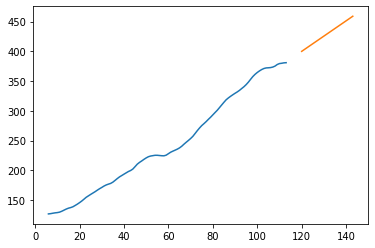

In [508]:
fig, ax = plt.subplots()
ax.plot(x_train, model1.trend.values.squeeze())
ax.plot(x_test,trend_test.squeeze())

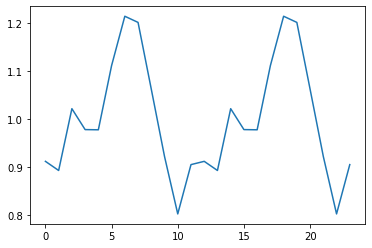

In [509]:
plt.plot(model1.seasonal.values.squeeze()[0:data_test.size])

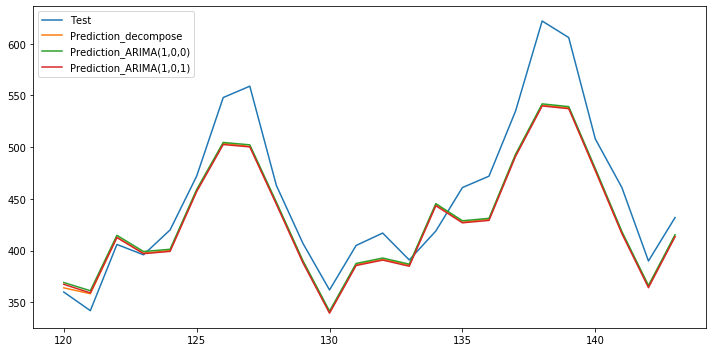

In [515]:
fig, ax = plt.subplots(figsize=(10,5))
#ax.plot(x_train, data_train, label = 'Train')
ax.plot(x_test, data_test, label = 'Test')
ax.plot(x_test, prediction_mean_mult, label = 'Prediction_decompose')
ax.plot(x_test, forecast2_full + 1, label = 'Prediction_ARIMA(1,0,0)')
ax.plot(x_test, forecast1_full - 1, label = 'Prediction_ARIMA(1,0,1)')
ax.legend()
plt.tight_layout()
#ax.set_ylim((0,10))

In [469]:
forecast1

array([1.0012707 , 1.00018034, 0.99991038, 0.99984354, 0.999827  ,
       0.9998229 , 0.99982189, 0.99982163, 0.99982157, 0.99982156,
       0.99982155, 0.99982155, 0.99982155, 0.99982155, 0.99982155,
       0.99982155, 0.99982155, 0.99982155, 0.99982155, 0.99982155,
       0.99982155, 0.99982155, 0.99982155, 0.99982155])

In [521]:
mu, sigma = scipy.stats.norm.fit(model1.resid.dropna())

In [523]:
sigma

0.031168626299925457

## OPCION 2 PRUEBA 

In [532]:
# Voy a hacer arima sobre la función data_train original con log() y sin diferenciar 
data_train = data.iloc[range(TRAIN_SIZE)]
data_test = data.iloc[range(TRAIN_SIZE, data.size)]
x_train = np.array(range(0, data_train.size))
x_test = np.array(range(data_train.size, data.size))

In [533]:
trainn = np.log(data_train)

modelextra = ARIMA(trainn.values.reshape(-1,1), order = (1, 1, 0))
model_fitext = modelextra.fit(disp=0)
print(model_fitext.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  119
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 100.923
Method:                       css-mle   S.D. of innovations              0.104
Date:                Thu, 16 Apr 2020   AIC                           -195.846
Time:                        17:34:27   BIC                           -187.508
Sample:                             1   HQIC                          -192.460
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0095      0.012      0.817      0.416      -0.013       0.032
ar.L1.D.y      0.1829      0.090      2.033      0.044       0.007       0.359
                                    Roots           

In [534]:
forecastextra = np.exp(model_fitext.forecast(steps = 24)[0])   #Si lo hacemos sobre una funcion que no estacionaria 
                                                                #sale un churro

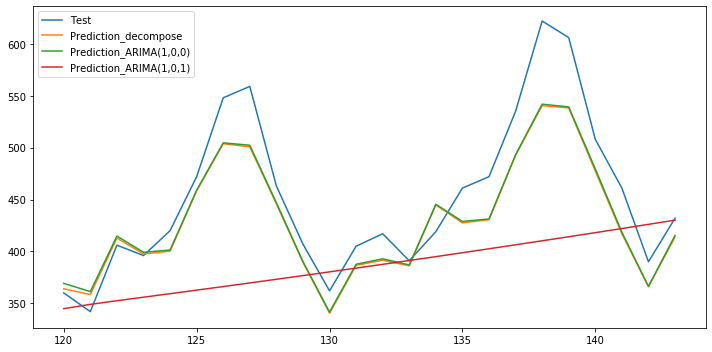

In [535]:
fig, ax = plt.subplots(figsize=(10,5))
#ax.plot(x_train, data_train, label = 'Train')
ax.plot(x_test, data_test, label = 'Test')
ax.plot(x_test, prediction_mean_mult, label = 'Prediction_decompose')
ax.plot(x_test, forecast2_full + 1, label = 'Prediction_ARIMA(1,0,0)')
ax.plot(x_test, forecastextra, label = 'Prediction_ARIMA(1,0,1)')
ax.legend()
plt.tight_layout()
#ax.set_ylim((0,10))

## OPCION C: SARIMA

In [8]:
TEST_SIZE = 24
data_train, data_test = data.iloc[:-TEST_SIZE], data.iloc[-TEST_SIZE:]
data_train.size
x_train = np.array(range(data_train.size))
x_test = np.array(range(data_train.size, data.size))

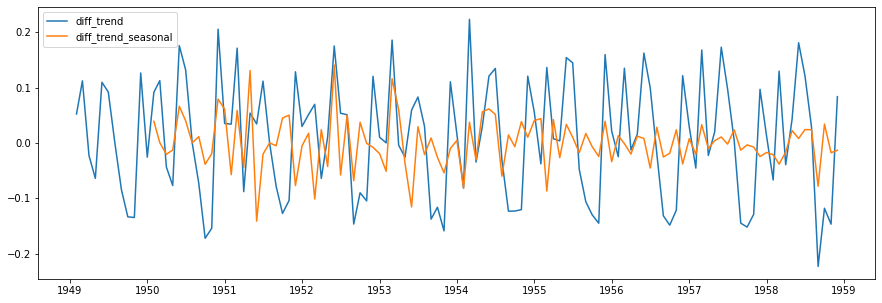

In [9]:
# Voy a quitarle la heterocedasticidad y a diferenciarlo una vez (así quito la tendencia)
train1 = np.log(data_train)
train2 = train1.diff()
  #Mantiene la estacionalidad
train3 = train2.diff(12)
trainx = train1.diff(12).dropna()
fig, ax = plt.subplots(1, 1, figsize=(15,5))
ax.plot(train2, label='diff_trend')
ax.plot(train3, label='diff_trend_seasonal')
plt.legend()
plt.show()

In [10]:
# Compruebo que sea estacionaria

from statsmodels.tsa.stattools import adfuller
results1 = adfuller(train2.dropna().values.squeeze())
results2 = adfuller(train3.dropna().values.squeeze())

print('p-value de la funcion diferenciada = ', results1[1])   #
print('p-value de la funcion diferenciada y seasonal diferenciada = ', results2[1])
# Por lo tanto diferenciandola una vez no le quito la seasonality y no es estacionaria (solo le he quitado el trend)
#Si la diferencio una vez y la diferencio en seasonality la convierto en estacionaria (rechazo hipotesis ADF)
#Por lo tanto orden d = 1, D = 1

p-value de la funcion diferenciada =  0.15842238699552352
p-value de la funcion diferenciada y seasonal diferenciada =  0.0013865309340907257


(-1, 10)

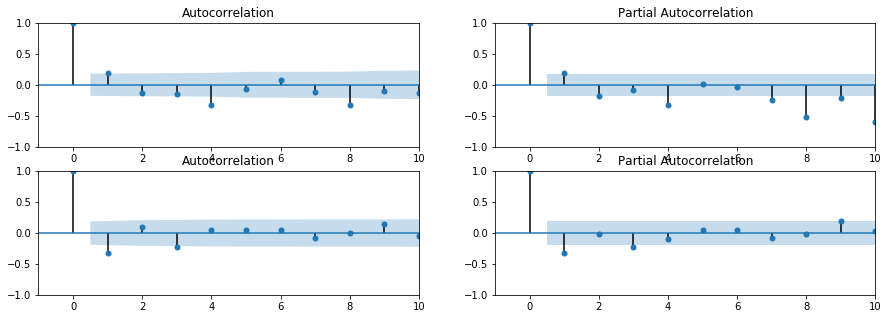

In [11]:
# Miro ordenes p, q, P Y Q -- 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 2, figsize=(15,5))
plot_acf(train2.dropna().values.squeeze(), ax = ax[0][0])
plot_pacf(train2.dropna().values.squeeze(), ax = ax[0][1])
ax[0][0].set_ylim((-1,1))
ax[0][0].set_xlim((-1,10))
ax[0][1].set_ylim((-1,1))
ax[0][1].set_xlim((-1,10))
plot_acf(train3.dropna().values.squeeze(), ax = ax[1][0])
plot_pacf(train3.dropna().values.squeeze(), ax = ax[1][1])
ax[1][0].set_ylim((-1,1))
ax[1][0].set_xlim((-1,10))
ax[1][1].set_ylim((-1,1))
ax[1][1].set_xlim((-1,10))

#Segun los plots ACF y PACF Probaré con p = 1, q = 1, P = 1, Q = 1. También podemos buscar usando un bucle para el AIC
#SARIMA(1,1,1)(1,1,1)12  

In [12]:
#APLICO SARIMA:

from statsmodels.tsa.statespace.sarimax import SARIMAX

In [18]:
SARModel = SARIMAX(train1, order = (1, 1, 1), seasonal_order = (1, 1, 1, 12),  
                   enforce_stationarity= False, enforce_invertibility = False)
results = SARModel.fit()

/home/oscar/anaconda3/envs/masters/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/oscar/anaconda3/envs/masters/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [16]:
model = SARIMAX

In [ ]:
model()

In [590]:
print(results.summary())
# Viendo los p-values usaré solo ma.L1 y ar.S.L2

                                 Statespace Model Results                                 
Dep. Variable:                         Passengers   No. Observations:                  120
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 171.311
Date:                            Fri, 17 Apr 2020   AIC                           -332.622
Time:                                    12:06:43   BIC                           -319.959
Sample:                                01-01-1949   HQIC                          -327.509
                                     - 12-01-1958                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0505      0.255      0.198      0.843      -0.449       0.550
ma.L1         -0.4645      0.235   

In [47]:
SARModel = SARIMAX(train1.values.reshape(-1,1), order = (0, 1, 1), seasonal_order = (1, 1, 0, 12),  
                   enforce_stationarity= False, enforce_invertibility = False)
results = SARModel.fit()
pred = np.exp(pd.DataFrame(predictions.predicted_mean))

In [ ]:
results.get_prediction(start = )

In [676]:
results.aic

-343.4518976988509

In [592]:
print(results.summary())  # P-values bien, ha disminuido también AIC, que es buena señal

                                 Statespace Model Results                                 
Dep. Variable:                         Passengers   No. Observations:                  120
Model:             SARIMAX(0, 1, 1)x(1, 1, 0, 12)   Log Likelihood                 174.726
Date:                            Fri, 17 Apr 2020   AIC                           -343.452
Time:                                    12:07:26   BIC                           -335.790
Sample:                                01-01-1949   HQIC                          -340.356
                                     - 12-01-1958                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4308      0.091     -4.732      0.000      -0.609      -0.252
ar.S.L12      -0.4437      0.083   

In [48]:
pred = results.get_forecast(steps = 24)

In [ ]:
pred = results.get_prediction()

In [43]:
pred.predicted

In [45]:
predd= pd.DataFrame(pred.predicted_mean )
predd.fillna(0, inplace = True)
#pred = np.array(pred)

In [52]:
predd.shape[0]

24

In [38]:
np.array(predictions.predicted_mean)

array([5.85347318, 5.79606832, 5.9425872 , 5.9105457 , 5.9428789 ,
       6.12025529, 6.23069768, 6.24826412, 6.0597581 , 5.92661249,
       5.78771584, 5.87711034, 5.90095633, 5.83934986, 5.97837439,
       5.94305629, 5.97975837, 6.15871404, 6.27387446, 6.29611117,
       6.09226869, 5.96578815, 5.82341424, 5.91020353])

In [26]:
pred = np.exp(predictions.predicted_mean).values
pred

array([348.95479658, 330.36898979, 382.53260154, 370.97365124,
       382.68140949, 456.50314808, 509.44350266, 517.20403431,
       430.1949593 , 376.10511139, 327.68015143, 359.06297823,
       367.97042703, 346.73548809, 398.89068402, 385.54989476,
       399.40584974, 477.27975076, 534.94050742, 545.78242716,
       447.28618197, 393.47760603, 341.65403543, 373.24419404])

In [612]:
data_test.head(4)

,Passengers
Month,
1959-01-01,360
1959-02-01,342
1959-03-01,406
1959-04-01,396


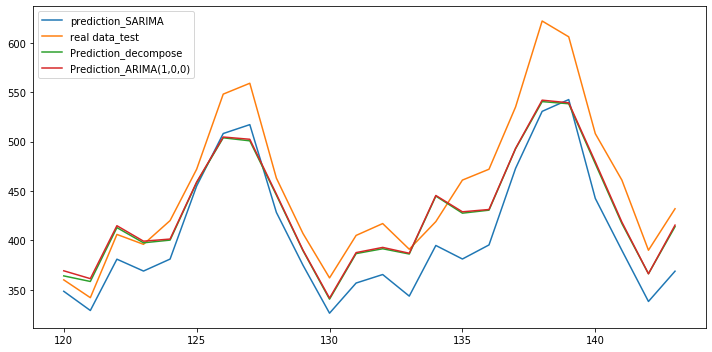

In [620]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x_test, pred, label = 'prediction_SARIMA')
ax.plot(x_test, data_test, label = 'real data_test')
#ax.plot(x_train, data_train, label = 'Train')
ax.plot(x_test, prediction_mean_mult, label = 'Prediction_decompose')
ax.plot(x_test, forecast2_full + 1, label = 'Prediction_ARIMA(1,0,0)')
ax.legend()
plt.tight_layout()
#ax.set_ylim((0,10))

In [624]:
# Ahora miramos metricas de evaluacion
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

dtest = data_test.values.squeeze()
print("mae de SARIMA: ", mae(dtest, pred))
print("rmse de SARIMA: ", np.sqrt(mse(dtest, pred)), '\n')

print("mae de Decompose: ", mae(dtest, prediction_mean_mult))
print("rmse de Decompose: ", np.sqrt(mse(dtest, prediction_mean_mult)), '\n')

print("mae de ARIMA del ruido: ", mae(dtest, forecast2_full))
print("rmse de ARIMA del ruido: ", np.sqrt(mse(dtest, forecast2_full)))

mae de SARIMA:  46.396782470208905
rmse de SARIMA:  51.104572069479204 

mae de Decompose:  28.256353523240424
rmse de Decompose:  34.5331777251477 

mae de ARIMA del ruido:  28.527389773654523
rmse de ARIMA del ruido:  34.521434577930826


In [ ]:
# Con SARIMA no hemos mejorado el resultado, vamos a hacer un grid search para encontrar los ordenes óptimos para SARIMA 


In [657]:
import itertools
p = q = range(0, 3)
#pdq = list(itertools.product(p, d, q))
pq = list(itertools.product(p, q))

In [658]:
aic_list = []
param_list = []
for param in pq:
    for seas in pq:
        SARModel = SARIMAX(train1, order = (param[0], 1, param[1]), seasonal_order = (seas[0], 1, seas[1], 12),  
                           enforce_stationarity= False, enforce_invertibility = False)

        results = SARModel.fit()
        aic_list.append(results.aic)
        param_list.append([param, seas])


/home/om/anaconda3/envs/masters/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/om/anaconda3/envs/masters/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/om/anaconda3/envs/masters/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/om/anaconda3/envs/masters/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/om/anaconda3/envs/masters/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimizati

/home/om/anaconda3/envs/masters/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/om/anaconda3/envs/masters/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/om/anaconda3/envs/masters/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/om/anaconda3/envs/masters/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/om/anaconda3/envs/masters/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information wa

/home/om/anaconda3/envs/masters/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/om/anaconda3/envs/masters/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/om/anaconda3/envs/masters/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/om/anaconda3/envs/masters/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/om/anaconda3/envs/masters/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency infor

In [664]:
np.argmin(aic_list), aic_list[27],  param_list[27]

(27, -359.9773188346232, [(1, 0), (0, 0)])

In [740]:
# Probamos el nuevo modelo para los valores óptimos de AIC considerando dif, dif_seasonal = 1

SARModel = SARIMAX(train1, order = (1, 1, 0), seasonal_order = (0, 1, 0, 12),  
                   enforce_stationarity= False, enforce_invertibility = False)
    
results = SARModel.fit()

results.aic

/home/om/anaconda3/envs/masters/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


-359.9773188346232

In [741]:
predictions = results.get_forecast(steps = 24)

In [742]:
pred2 = np.exp(pd.DataFrame(predictions.predicted_mean))

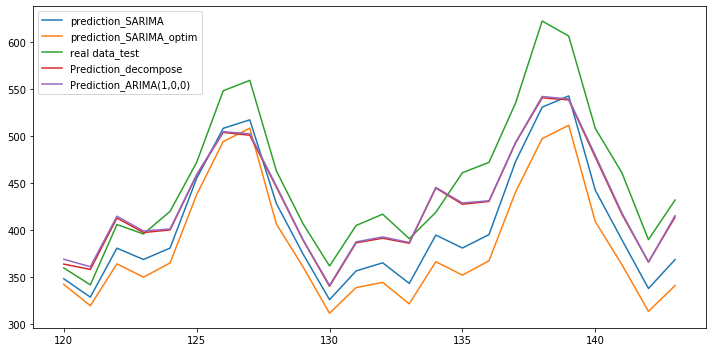

In [743]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x_test, pred, label = 'prediction_SARIMA')
ax.plot(x_test, pred2, label = 'prediction_SARIMA_optim')
ax.plot(x_test, data_test, label = 'real data_test')
#ax.plot(x_train, data_train, label = 'Train')
ax.plot(x_test, prediction_mean_mult, label = 'Prediction_decompose')
ax.plot(x_test, forecast2_full + 1, label = 'Prediction_ARIMA(1,0,0)')
ax.legend()
plt.tight_layout()
#ax.set_ylim((0,10))

In [706]:
dtest = data_test.values.squeeze()
print("mae de SARIMA: ", mae(dtest, pred))
print("rmse de SARIMA: ", np.sqrt(mse(dtest, pred)), '\n')

print("mae de SARIMA2: ", mae(dtest, pred2))
print("rmse de SARIMA2: ", np.sqrt(mse(dtest, pred2)), '\n')

print("mae de Decompose: ", mae(dtest, prediction_mean_mult))
print("rmse de Decompose: ", np.sqrt(mse(dtest, prediction_mean_mult)), '\n')

print("mae de ARIMA del ruido: ", mae(dtest, forecast2_full))
print("rmse de ARIMA del ruido: ", np.sqrt(mse(dtest, forecast2_full)))

mae de SARIMA:  46.396782470208905
rmse de SARIMA:  51.104572069479204 

mae de SARIMA2:  48.03497262290511
rmse de SARIMA2:  51.75111278061888 

mae de Decompose:  28.256353523240424
rmse de Decompose:  34.5331777251477 

mae de ARIMA del ruido:  28.527389773654523
rmse de ARIMA del ruido:  34.521434577930826


In [824]:
# Para conseguir predecir mejor voy a intentar capturar la tendencia por regresion lineal pesada y luego aplicaré SARIMA
# Me he dado cuenta que las curvas salen por debajo que la solución. 
# También de train no meteré los tres primeros años

In [854]:
data = pd.read_csv('AirPassengers.csv', header = 0, parse_dates = ['Month'], index_col = 'Month')
data[['Passengers']] = data[['#Passengers']] ; data.drop('#Passengers', axis = 1, inplace = True)

TEST_SIZE = 24
data_train, data_test = data.iloc[36:-TEST_SIZE], data.iloc[-TEST_SIZE:]
data_train.size
x_train = np.array(range(36, data_train.size + 36))
x_test = np.array(range(36 + data_train.size, data.size))

In [860]:
# Voy a quitarle la heterocedasticidad y quitarle la tendencia con una regresion lineal pesada
train1 = np.log(data_train)
trainmovil = train1.ewm(12).mean()

from sklearn.linear_model import LinearRegression

linearmodel = LinearRegression()
linearmodel.fit(x_train.reshape(-1,1), trainmovil, sample_weight = [i ** 2 for i in x_train])

trendd = linearmodel.predict(x_train.reshape(-1,1))
  #Mantiene la estacionalidad

train222 = train1- trendd

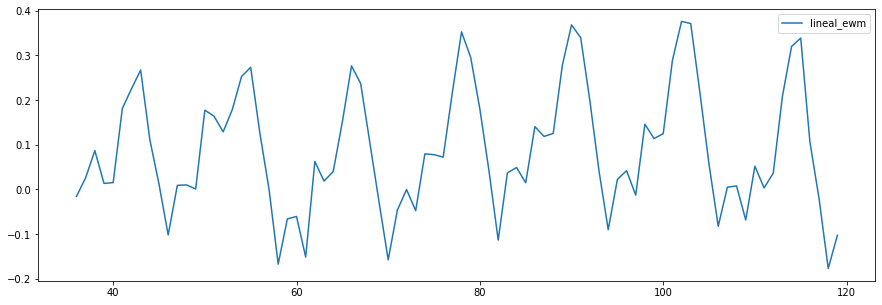

In [891]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))
#ax.plot(x_train, train22, label='polin')
ax.plot(x_train, train222, label='lineal_ewm')
#ax.plot(x_train, (train22 + train222.values.squeeze())/2, label='Media')
plt.legend()

In [861]:
# Pruebo de quitarle la tendencia con una regresión polinomica:   
p = np.poly1d(np.polyfit(x_train.squeeze(), train1.values.squeeze(), 3))
y_pred_pr2 = p(x_train.squeeze())
train22 = train1.values.squeeze() - y_pred_pr2


In [870]:
# Opto por regresión polinomica de grado 3 y aplico SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

SARModel = SARIMAX(train222, order = (0, 0, 1), seasonal_order = (1, 1, 0, 12),  
                   enforce_stationarity= False, enforce_invertibility = False)
results = SARModel.fit()


/home/om/anaconda3/envs/masters/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/om/anaconda3/envs/masters/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


In [880]:
predictions = results.get_forecast(steps = 24)
prediction = predictions.predicted_mean

In [889]:
# Monto la prediccion

#predicted_SARIMA_adj = np.exp(prediction + p(x_test.squeeze())) 
predicted_SARIMA_adj = np.exp(prediction.values.squeeze() + (linearmodel.predict(x_test.reshape(-1,1))).squeeze())

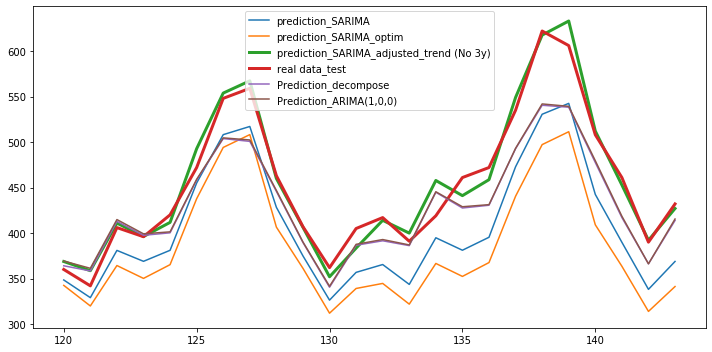

In [908]:
#################Plot comparativo

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x_test, pred, label = 'prediction_SARIMA')
ax.plot(x_test, pred2, label = 'prediction_SARIMA_optim')
ax.plot(x_test, predicted_SARIMA_adj, label = 'prediction_SARIMA_adjusted_trend (No 3y)',lw=3)
ax.plot(x_test, data_test, label = 'real data_test', lw=3)
#ax.plot(x_train, data_train, label = 'Train')
ax.plot(x_test, prediction_mean_mult, label = 'Prediction_decompose')
ax.plot(x_test, forecast2_full + 1, label = 'Prediction_ARIMA(1,0,0)')
ax.legend()
plt.tight_layout()
#ax.set_ylim((0,10))

In [896]:
#########################METRICAS EVALUACION

dtest = data_test.values.squeeze()
print("mae de SARIMA: ", mae(dtest, pred))
print("rmse de SARIMA: ", np.sqrt(mse(dtest, pred)), '\n')

print("mae de SARIMA2: ", mae(dtest, pred2))
print("rmse de SARIMA2: ", np.sqrt(mse(dtest, pred2)), '\n')

print("mae de adjusted trend SARIMA: ", mae(dtest, predicted_SARIMA_adj))
print("rmse de adjusted trend SARIMA: ", np.sqrt(mse(dtest, predicted_SARIMA_adj)), '\n')

print("mae de Decompose: ", mae(dtest, prediction_mean_mult))
print("rmse de Decompose: ", np.sqrt(mse(dtest, prediction_mean_mult)), '\n')

print("mae de ARIMA del ruido: ", mae(dtest, forecast2_full))
print("rmse de ARIMA del ruido: ", np.sqrt(mse(dtest, forecast2_full)))

mae de SARIMA:  46.396782470208905
rmse de SARIMA:  51.104572069479204 

mae de SARIMA2:  67.63206988387002
rmse de SARIMA2:  73.21988725959591 

mae de adjusted trend SARIMA:  10.729041127654908
rmse de adjusted trend SARIMA:  14.10098765231073 

mae de Decompose:  28.256353523240424
rmse de Decompose:  34.5331777251477 

mae de ARIMA del ruido:  28.527389773654523
rmse de ARIMA del ruido:  34.521434577930826


In [895]:
# En conclusion aplicar SARIMA habiendo capturado la heterocedasticidad y la tendencia con regresion lineal pesada nos da
# la prediccion más ajustada

In [901]:
#Otras variaciones: prueba de quitarle los 3 meses solo para la regresión lineal pero al SARIMA le paso toda los años de train.
#A) Varia muy poco la predicción, es más acurada la anterior

#B) Pruebo de usar toda la serie entera



/home/om/anaconda3/envs/masters/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/om/anaconda3/envs/masters/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/home/om/anaconda3/envs/masters/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
/home/om/anaconda3/envs/masters/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/om/anaconda3/envs/masters/lib/python3.7/site-packages/statsmodels/

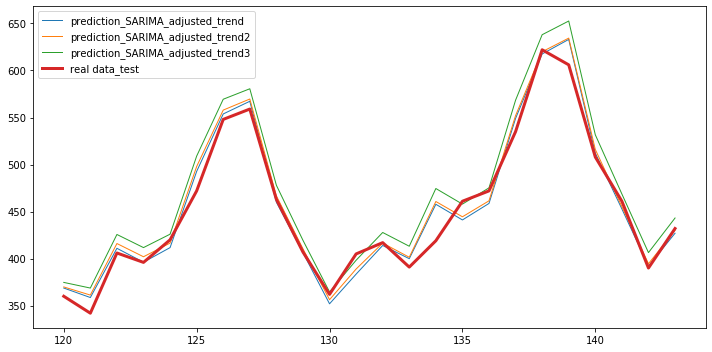

In [923]:
data = pd.read_csv('AirPassengers.csv', header = 0, parse_dates = ['Month'], index_col = 'Month')
data[['Passengers']] = data[['#Passengers']] ; data.drop('#Passengers', axis = 1, inplace = True)

##A
TEST_SIZE = 24
data_train, data_test = data.iloc[36:-TEST_SIZE], data.iloc[-TEST_SIZE:]
data_train.size
x_train = np.array(range(36, data_train.size + 36))
x_test = np.array(range(36 + data_train.size, data.size))

data_train2, data_test2 = data.iloc[:-TEST_SIZE], data.iloc[-TEST_SIZE:]
x_train2 = np.array(range(data_train2.size))
x_test2 = np.array(range(data_train2.size, data.size))
# Voy a quitarle la heterocedasticidad y quitarle la tendencia con una regresion lineal pesada
train1 = np.log(data_train)
train0 = np.log(data_train2)
trainmovil = train1.ewm(12).mean()

from sklearn.linear_model import LinearRegression

linearmodel = LinearRegression()
linearmodel.fit(x_train.reshape(-1,1), trainmovil, sample_weight = [i ** 2 for i in x_train])

trendd = linearmodel.predict(x_train2.reshape(-1,1))
  #Mantiene la estacionalidad

train222 = train0- trendd

# Aplico SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

SARModel = SARIMAX(train222, order = (0, 0, 1), seasonal_order = (1, 1, 0, 12),  
                   enforce_stationarity= False, enforce_invertibility = False)
results = SARModel.fit()

predictions = results.get_forecast(steps = 24)
prediction = predictions.predicted_mean
predicted_SARIMA_adj2 = np.exp(prediction.values.squeeze() + (linearmodel.predict(x_test2.reshape(-1,1))).squeeze())

##B
TEST_SIZE = 24
data_train, data_test = data.iloc[:-TEST_SIZE], data.iloc[-TEST_SIZE:]
x_train = np.array(range(data_train2.size))
x_test = np.array(range(data_train2.size, data.size))
# Voy a quitarle la heterocedasticidad y quitarle la tendencia con una regresion lineal pesada
train = np.log(data_train)
trainmovil = train.ewm(12).mean()

from sklearn.linear_model import LinearRegression

linearmodel = LinearRegression()
linearmodel.fit(x_train.reshape(-1,1), trainmovil, sample_weight = [i ** 2 for i in x_train])

trendd = linearmodel.predict(x_train.reshape(-1,1))
  #Mantiene la estacionalidad

train222 = train- trendd

# Opto por regresión polinomica de grado 3 y aplico SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

SARModel = SARIMAX(train222, order = (0, 0, 1), seasonal_order = (1, 1, 0, 12),  
                   enforce_stationarity= False, enforce_invertibility = False)
results = SARModel.fit()

predictions = results.get_forecast(steps = 24)
prediction = predictions.predicted_mean
predicted_SARIMA_adj3 = np.exp(prediction.values.squeeze() + (linearmodel.predict(x_test.reshape(-1,1))).squeeze())


fig, ax = plt.subplots(figsize=(10,5))

ax.plot(x_test, predicted_SARIMA_adj, label = 'prediction_SARIMA_adjusted_trend',lw=1)
ax.plot(x_test, predicted_SARIMA_adj2, label = 'prediction_SARIMA_adjusted_trend2',lw=1)
ax.plot(x_test, predicted_SARIMA_adj3, label = 'prediction_SARIMA_adjusted_trend3',lw=1)
ax.plot(x_test, data_test, label = 'real data_test', lw=3)
#ax.plot(x_train, data_train, label = 'Train')
ax.legend()
plt.tight_layout()
#ax.set_ylim((0,10))

In [924]:
print("mae de adjusted trend SARIMA: ", mae(dtest, predicted_SARIMA_adj))
print("rmse de adjusted trend SARIMA: ", np.sqrt(mse(dtest, predicted_SARIMA_adj)), '\n')

print("mae de adjusted2 trend SARIMA: ", mae(dtest, predicted_SARIMA_adj2))
print("rmse de adjusted2 trend SARIMA: ", np.sqrt(mse(dtest, predicted_SARIMA_adj2)), '\n')

print("mae de adjusted3 trend SARIMA: ", mae(dtest, predicted_SARIMA_adj3))
print("rmse de adjusted3 trend SARIMA: ", np.sqrt(mse(dtest, predicted_SARIMA_adj3)), '\n')

#La mejor es la que no considera los primeros 3 años para nada

mae de adjusted trend SARIMA:  10.729041127654908
rmse de adjusted trend SARIMA:  14.10098765231073 

mae de adjusted2 trend SARIMA:  11.311160369689942
rmse de adjusted2 trend SARIMA:  14.823743500042543 

mae de adjusted3 trend SARIMA:  18.719980451695744
rmse de adjusted3 trend SARIMA:  22.90484231448501 



In [ ]:
# No es justo comparar así los modelos, creo que no incluir los 3 primeros años favorece al ultimo modelo, por lo tanto
# lo haré también para descomposición y el SARIMA con diferenciacion y el ARIMA usando el error

In [916]:
data = pd.read_csv('AirPassengers.csv', header = 0, parse_dates = ['Month'], index_col = 'Month')
data[['Passengers']] = data[['#Passengers']] ; data.drop('#Passengers', axis = 1, inplace = True)
TEST_SIZE = 24
data_train, data_test = data.iloc[36:-TEST_SIZE], data.iloc[-TEST_SIZE:]
data_train.size
x_train = np.array(range(36, data_train.size + 36))
x_test = np.array(range(36 + data_train.size, data.size))

In [917]:
#Descomposicion sin contar primeros 3 años

model2 = seasonal_decompose(data_train, model = 'multiplicative')
model2.resid.dropna(inplace = True)
mu, sigma = scipy.stats.norm.fit(model2.resid)
N_SAMPLES = 1000
err_test = np.random.normal(mu, sigma, size = (N_SAMPLES, data_test.size))
df = pd.DataFrame({'a' : model2.trend.values.squeeze(), 'b' : x_train} )
df.dropna(inplace = True)
modelreg = LinearRegression()
modelreg.fit(df[['b']], df[['a']])
trend_test = modelreg.predict(x_test.reshape(-1, 1))
prediction = err_test * model2.seasonal.values.squeeze()[0:data_test.size] * trend_test.squeeze()
prediction_mean_mult = pd.DataFrame(prediction).apply(np.mean, axis = 0)

In [920]:
#SARIMA con diferenciacion 
train1 = np.log(data_train)

SARModel = SARIMAX(train1, order = (0, 1, 1), seasonal_order = (1, 1, 0, 12),  
                   enforce_stationarity= False, enforce_invertibility = False)
results = SARModel.fit()
predictions = results.get_forecast(steps = 24)
pred00 = np.exp(pd.DataFrame(predictions.predicted_mean))


/home/om/anaconda3/envs/masters/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/om/anaconda3/envs/masters/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/home/om/anaconda3/envs/masters/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/om/anaconda3/envs/masters/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


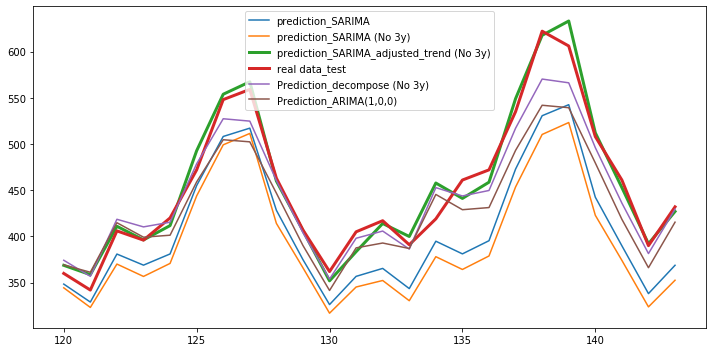

In [921]:
#################Plot comparativo

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x_test, pred, label = 'prediction_SARIMA')
ax.plot(x_test, pred00, label = 'prediction_SARIMA (No 3y)')
ax.plot(x_test, predicted_SARIMA_adj, label = 'prediction_SARIMA_adjusted_trend (No 3y)',lw=3)
ax.plot(x_test, data_test, label = 'real data_test', lw=3)
ax.plot(x_test, prediction_mean_mult, label = 'Prediction_decompose (No 3y)')
ax.plot(x_test, forecast2_full + 1, label = 'Prediction_ARIMA(1,0,0)')
ax.legend()
plt.tight_layout()
#ax.set_ylim((0,10))

In [922]:
# Aqui no hemos considerado los 3 primeros años
print("mae de adjusted trend SARIMA: ", mae(dtest, predicted_SARIMA_adj))
print("rmse de adjusted trend SARIMA: ", np.sqrt(mse(dtest, predicted_SARIMA_adj)), '\n')

print("mae de SARIMA: ", mae(dtest, pred00))
print("rmse de SARIMA: ", np.sqrt(mse(dtest, pred00)), '\n')

print("mae de Decompose: ", mae(dtest, prediction_mean_mult))
print("rmse de Decompose: ", np.sqrt(mse(dtest, prediction_mean_mult)), '\n')

# Ha mejorado la descomposicion y generacion de ruido pero es mejor SARIMA

mae de adjusted trend SARIMA:  10.729041127654908
rmse de adjusted trend SARIMA:  14.10098765231073 

mae de SARIMA:  59.48172631372458
rmse de SARIMA:  64.5375330839936 

mae de Decompose:  16.223173571328672
rmse de Decompose:  20.51431369767358 

